In [1]:
import numpy as np
import pandas as pd


In [2]:
df = pd.read_csv("datasets/cleaned_online_sex_work.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   User_ID                              28831 non-null  int64  
 1   Female                               28831 non-null  bool   
 2   Age                                  28831 non-null  float64
 3   Location                             28831 non-null  object 
 4   Verification                         28831 non-null  bool   
 5   Heterosexual                         28831 non-null  int64  
 6   Homosexual                           28831 non-null  int64  
 7   bicurious                            28831 non-null  int64  
 8   bisexual                             28831 non-null  int64  
 9   Dominant                             28831 non-null  int64  
 10  Submisive                            28831 non-null  int64  
 11  Switch                      

### Data preprocessing

In [4]:
truth_map = {True: 1, False: 0}

df['Female'] = df['Female'].map(truth_map)
df['Verification'] = df['Verification'].map(truth_map)

#too many categories, so we take the top 10 and make dummies
top_10 = df['Location'].value_counts().head(10).index.to_list()

def dummies(d, var, top10):
    for label in top10:
        d[var+'_'+label] = np.where(df[var] == label, 1, 0)

dummies(df, 'Location', top_10)
df.drop('Location', axis = 1, inplace = True)

df.drop(['User_ID', 'Friends_ID_list'], axis = 1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Female                               28831 non-null  int64  
 1   Age                                  28831 non-null  float64
 2   Verification                         28831 non-null  int64  
 3   Heterosexual                         28831 non-null  int64  
 4   Homosexual                           28831 non-null  int64  
 5   bicurious                            28831 non-null  int64  
 6   bisexual                             28831 non-null  int64  
 7   Dominant                             28831 non-null  int64  
 8   Submisive                            28831 non-null  int64  
 9   Switch                               28831 non-null  int64  
 10  Men                                  28831 non-null  int64  
 11  Men_and_Women               

In [6]:
from tensorflow import keras
import keras_tuner as kt

In [9]:
def build_model(hp):
    ''' 
    model-building function given the hyperparameters
    '''
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=10, max_value=400, step=10),
                activation=hp.Choice("activation", ["relu", "tanh", "swish"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(rate=0.20))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = build_model(kt.HyperParameters())

In [10]:
def get_best_model(tuner):
    ''' 
    gets best model after searching
    '''
    models = tuner.get_best_models(num_models=2)
    best_model = models[0]
    best_model.build(input_shape=(None, 18))
    return best_model

In [11]:
def define_tuner():
  ''' 
  tuner which searches for best hyperparameters
  '''
  return kt.RandomSearch(
      hypermodel=build_model,
      objective="val_accuracy",
      max_trials=12,
      executions_per_trial=1,
      overwrite=True,
      directory="my_dir",
      project_name="helloworld",
  )

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def scaled_splits(df):
    '''
    returns train and test splits and scales them for training in model
    '''
    X = df.drop(['Risk'], axis =1)
    y = df['Risk'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = y_train.reshape(y_train.shape[0], 1)
    return X_train, X_test, y_train, y_test

In [13]:
def view_splits(df):
    ''' 
    splits dataset into 2 views
    '''
    X = df.drop('Risk', axis = 1)
    l = list(X.columns)
    np.random.shuffle(l)
    return l[:18], l[18:]

In [14]:
x1, x2 = view_splits(df)
v1 = df[x1+['Risk']]
v2 = df[x2+['Risk']]

In [15]:
# columns contained in both views
x1, x2

(['Nobody_but_maybe',
  'Homosexual',
  'Member_since_month',
  'Points_Rank',
  'Women',
  'bicurious',
  'Age',
  'bisexual',
  'Member_since_day',
  'Location_E',
  'Heterosexual',
  'Location_K',
  'Location_C',
  'Verification',
  'Profile_pictures',
  'Submisive',
  'Number_of_offline_meetings_attended',
  'Number_of_Comments_in_public_forum'],
 ['Number_of_advertisments_posted',
  'Location_M',
  'Location_B',
  'Location_L',
  'Female',
  'Switch',
  'Men',
  'Last_login',
  'Location_G',
  'Dominant',
  'Location_H',
  'Location_O',
  'Number of Friends',
  'Men_and_Women',
  'Member_since_year',
  'Location_A',
  'Time_spent_chating_H:M',
  'Nobody'])

In [16]:
# getting labelled and unlabelled views

v1_l = v1.dropna()
v2_l = v2.dropna()
v1_u = v1[v1['Risk'].isna()]
v2_u = v2[v2['Risk'].isna()]

In [17]:
# calbacks to prevent overfitting

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [18]:
def get_pseudo_labels(model, unlabelled_df):
    ''' 
    finds pseudolabels for a given unlabelled set of data
    '''
    return model.predict(unlabelled_df)

In [19]:
def get_confident_labels(pseudolabels):
    ''' 
    filters prediction based on how confident the model is in predicting the output
    '''
    confident_labels = []
    confidence_level = np.percentile(pseudolabels, 90)
    for i in pseudolabels:
        value = i[0]
        if value >= confidence_level:
            confident_labels.append([1, 1])
        elif value <= 1-confidence_level:
            confident_labels.append([0, 1])
        else:
            confident_labels.append([value, 0])
    return pd.DataFrame(confident_labels, columns=["Risk", "confident"])


In [20]:
def co_training(labelled_view1, unlabelled_view1, labelled_view2, unlabelled_view2, current_model1 = None, current_model2 = None):

    if len(unlabelled_view1) > 0 and len(unlabelled_view2) > 0:

        # training first model based on first labelled view
        v1_l_xtrain, v1_l_xtest, v1_l_ytrain, v1_l_ytest = scaled_splits(labelled_view1)
        tuner1 = define_tuner()
        tuner1.search(v1_l_xtrain, v1_l_ytrain, epochs = 20, validation_data = (v1_l_xtest,v1_l_ytest))
        best_hps1 = tuner1.get_best_hyperparameters(5)
        model1 = build_model(best_hps1[0])

        # getting pseudolabels for first unlabelled view
        unlabelled_view1.drop('Risk', axis = 1, inplace = True)
        pseudolabels1 = get_pseudo_labels(model1, unlabelled_view1)

        # extracting indexes of all confidently predicted instances
        confidence_df1 = get_confident_labels(pseudolabels1)
        u1_conf = pd.concat([confidence_df1.reset_index(), unlabelled_view1.reset_index()], axis = 1)
        conf1 = u1_conf[u1_conf['confident'] == 1]
        unconf1 = u1_conf[u1_conf['confident'] == 0]
        u1_conf_indexes = conf1['index'].values[:,-1]

        # training first model based on second labelled view
        v2_l_xtrain, v2_l_xtest, v2_l_ytrain, v2_l_ytest = scaled_splits(labelled_view2)
        tuner2 = define_tuner()
        tuner2.search(v2_l_xtrain, v2_l_ytrain, epochs = 20, validation_data = (v2_l_xtest,v2_l_ytest))
        best_hps2 = tuner2.get_best_hyperparameters(5)
        model2 = build_model(best_hps2[0])

        # getting pseudolabels for second unlabelled view
        unlabelled_view2.drop('Risk', axis = 1, inplace = True)
        pseudolabels2 = get_pseudo_labels(model2, unlabelled_view2)

        # extracting indexes of all confidently predicted instances
        confidence_df2 = get_confident_labels(pseudolabels2)
        u2_conf = pd.concat([confidence_df2.reset_index(), unlabelled_view2.reset_index()], axis = 1)
        conf2 = u2_conf[u2_conf['confident'] == 1]
        unconf2 = u2_conf[u2_conf['confident'] == 0]
        u2_conf_indexes = conf2['index'].values[:,-1]
        
        # adding confident rows predicted by model 2 to labelled set of view 1
        confident_labels1 = pd.concat([unlabelled_view1.loc[u2_conf_indexes].reset_index(),conf2['Risk'].reset_index()], axis = 1)

        # adding confident rows predicted by model 1 to labelled set of view 2
        confident_labels2 = pd.concat([unlabelled_view2.loc[u1_conf_indexes].reset_index(),conf1['Risk'].reset_index()], axis = 1)

        new_unlabelled_view1 = unconf1.drop(['confident', 'index'], axis = 1)
        new_unlabelled_view2 = unconf2.drop(['confident', 'index'], axis = 1)

        new_labelled_view1 = pd.concat([labelled_view1, confident_labels1.drop(['index'], axis = 1)], axis = 0)
        new_labelled_view2 = pd.concat([labelled_view2, confident_labels2.drop(['index'], axis = 1)], axis = 0)
        
        return {'v1_l': new_labelled_view1,
                'v1_u': new_unlabelled_view1,
                'v2_l': new_labelled_view2,
                'v2_u': new_unlabelled_view2,
                'model1': model1,
                'model2': model2,
                'params1': best_hps1[0],
                'params2': best_hps2[0]}
    
    # self training if one of the unlabelled views is empty, i.e, if either model has predicted all unlabelled data confidently
    elif len(unlabelled_view1) > 0 and len(unlabelled_view2) == 0:
        xtrain, xtest, ytrain, ytest = scaled_splits(labelled_view1)
        tuner = define_tuner()
        tuner.search(xtrain, ytrain, epochs = 20, validation_data = (xtest,ytest), callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],)
        best_hps = tuner.get_best_hyperparameters(5)
        model = build_model(best_hps[0])

        unlabelled_view1 = unlabelled_view1.drop('Risk', axis = 1)
        pseudolabels = get_pseudo_labels(model, unlabelled_view1)

        confidence_df = get_confident_labels(pseudolabels)
        u_conf = pd.concat([confidence_df.reset_index(), unlabelled_view1.reset_index()], axis = 1)

        unconfident_rows = u_conf[u_conf['confident'] == 0]
        confident_rows = u_conf[u_conf['confident'] == 1]
        unconfident_rows.drop('index', axis = 1, inplace = True)
        confident_rows.drop('index', axis = 1, inplace = True)

        new_labelled_view1 = pd.concat([labelled_view1, confident_rows.drop(['confident'], axis = 1)], axis = 0)
        new_unlabelled_view1 = unconfident_rows.drop('confident', axis = 1)
        
        new_labelled_view2 = labelled_view2
        new_unlabelled_view2 = unlabelled_view2
        
        xtrain, xtest, ytrain, ytest = scaled_splits(labelled_view2)
        tuner = define_tuner()
        tuner.search(xtrain, ytrain, epochs = 20, validation_data = (xtest,ytest), callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],)
        best_hps2 = tuner.get_best_hyperparameters(5)
        model2 = build_model(best_hps2[0])
        
        return {'v1_l': new_labelled_view1,
                'v1_u': new_unlabelled_view1,
                'v2_l': new_labelled_view2,
                'v2_u': new_unlabelled_view2,
                'model1': model,
                'model2': model2,
                'params1': best_hps[0],
                'params2': best_hps2[0]}
    
    # self training if one of the unlabelled views is empty, i.e, if either model has predicted all unlabelled data confidently
    elif len(unlabelled_view1) == 0 and len(unlabelled_view2) > 0:
        xtrain, xtest, ytrain, ytest = scaled_splits(labelled_view2)
        tuner = define_tuner()
        tuner.search(xtrain, ytrain, epochs = 20, validation_data = (xtest,ytest), callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],)
        best_hps = tuner.get_best_hyperparameters(5)
        model2 = build_model(best_hps[0])

        unlabelled_view2 = unlabelled_view2.drop('Risk', axis = 1)
        pseudolabels = get_pseudo_labels(model2, unlabelled_view2)

        confidence_df = get_confident_labels(pseudolabels)
        u_conf = pd.concat([confidence_df.reset_index(), unlabelled_view2.reset_index()], axis = 1)

        unconfident_rows = u_conf[u_conf['confident'] == 0]
        confident_rows = u_conf[u_conf['confident'] == 1]
        unconfident_rows.drop('index', axis = 1, inplace = True)
        confident_rows.drop('index', axis = 1, inplace = True)

        new_labelled_view2 = pd.concat([labelled_view2, confident_rows.drop(['confident'], axis = 1)], axis = 0)
        new_unlabelled_view2 = unconfident_rows.drop('confident', axis = 1)
        
        new_labelled_view1 = labelled_view1
        new_unlabelled_view1 = unlabelled_view1
        
        xtrain, xtest, ytrain, ytest = scaled_splits(labelled_view1)
        tuner = define_tuner()
        tuner.search(xtrain, ytrain, epochs = 20, validation_data = (xtest,ytest), callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],)
        best_hps1 = tuner.get_best_hyperparameters(5)
        model1 = build_model(best_hps1[0])
        
        return {'v1_l': new_labelled_view1,
                'v1_u': new_unlabelled_view1,
                'v2_l': new_labelled_view2,
                'v2_u': new_unlabelled_view2,
                'model1': model1,
                'model2': model2,
                'params1': best_hps1[0],
                'params2': best_hps[0]}
    else:
        return {
            'model1': current_model1,
            'model2': current_model2
        } 
    

In [21]:
iter1 = co_training(v1_l, v1_u, v2_l, v2_u)

Trial 12 Complete [00h 00m 01s]
val_accuracy: 0.7222222089767456

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 00m 21s


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### We can see that the number of labelled rows has increased for both views, and the unlabelled views have 0 or few rows

In [22]:
iter1['v1_l']

,Nobody_but_maybe,Homosexual,Member_since_month,Points_Rank,Women,bicurious,Age,bisexual,Member_since_day,Location_E,Heterosexual,Location_K,Location_C,Verification,Profile_pictures,Submisive,Number_of_offline_meetings_attended,Number_of_Comments_in_public_forum,Risk
0,0,1,9,50,0,0,34.6,0,17,0,0,0,0,0,0,0,0,32,0.0
1,0,0,11,518,1,0,32.2,0,1,0,1,0,0,0,0,0,0,710,0.0
2,0,0,4,150,1,0,33.6,0,1,0,1,1,0,0,45,0,1,25,0.0
3,0,0,4,114,1,0,34.0,0,8,0,1,0,0,0,1,0,0,107,0.0
4,0,0,4,497,1,0,39.5,0,14,0,1,0,0,0,8,0,6,600,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22816,0,0,9,0,0,0,41.7,1,5,0,0,0,0,0,0,0,0,0,0.0
22817,0,0,9,0,0,0,32.4,1,5,0,0,0,0,0,0,0,0,0,0.0
22818,0,0,9,0,0,0,50.5,0,5,0,1,0,0,0,0,1,0,0,0.0
22819,0,0,9,15,0,1,46.4,0,5,0,0,0,0,0,0,1,0,0,0.0


In [23]:
iter1['v2_l']

,Number_of_advertisments_posted,Location_M,Location_B,Location_L,Female,Switch,Men,Last_login,Location_G,Dominant,Location_H,Location_O,Number of Friends,Men_and_Women,Member_since_year,Location_A,Time_spent_chating_H:M,Nobody,Risk
0,0,0,0,0,0,1,1,10,0,0,0,0,1,0,2012,1,2,0,0.0
1,9,0,0,0,0,0,0,1,0,1,0,0,7,0,2009,0,225,0,0.0
2,1,0,0,0,0,0,0,3,0,1,0,0,3,0,2013,0,135,0,0.0
3,1,0,0,0,0,0,0,4,0,1,1,0,12,0,2013,0,21562,0,0.0
4,0,0,1,0,0,0,0,5,0,1,0,0,35,0,2013,0,21,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28736,1,0,0,0,0,1,0,23,0,0,0,0,1,0,2012,0,3,0,0.0
28737,0,0,0,0,0,0,0,597,0,0,0,0,1,1,2012,0,0,0,0.0
28738,0,0,0,0,0,0,0,4,0,0,0,0,1,0,2012,0,0,0,0.0
28739,4,0,0,0,0,0,1,665,0,0,0,0,1,0,2012,0,174,0,0.0


In [24]:
iter1['v1_u']

,Risk,Nobody_but_maybe,Homosexual,Member_since_month,Points_Rank,Women,bicurious,Age,bisexual,Member_since_day,Location_E,Heterosexual,Location_K,Location_C,Verification,Profile_pictures,Submisive,Number_of_offline_meetings_attended,Number_of_Comments_in_public_forum


In [25]:
iter1['v2_u']

,Risk,Number_of_advertisments_posted,Location_M,Location_B,Location_L,Female,Switch,Men,Last_login,Location_G,Dominant,Location_H,Location_O,Number of Friends,Men_and_Women,Member_since_year,Location_A,Time_spent_chating_H:M,Nobody
2,0.985674,0,0,0,0,0,0,0,49,0,1,0,0,1,0,2012,0,1,0
8,0.995970,1,0,1,0,0,0,0,37,0,0,0,0,1,0,2012,0,0,1
9,0.999891,2,1,0,0,0,0,0,5,0,0,0,0,1,0,2012,0,0,1
10,0.999904,0,1,0,0,0,0,0,3,0,1,0,0,1,0,2012,0,0,1
33,0.999858,2,0,0,0,0,1,0,8,0,0,0,0,1,0,2012,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28733,0.993154,0,0,0,0,0,0,0,171,0,1,0,0,13,0,2012,1,358,0
28735,0.993440,0,0,0,0,0,0,0,42,0,1,0,0,1,0,2012,1,0,0
28736,0.999287,1,0,0,0,0,1,0,23,0,0,0,0,1,0,2012,0,3,0
28738,0.999895,0,0,0,0,0,0,0,4,0,0,0,0,1,0,2012,0,0,0


In [26]:
# iter2 = co_training(iter1['v1_l'], iter1['v1_u'], iter1['v2_l'], iter1['v2_u'], iter1['model1'], iter1['model2'])

In [48]:
# callbacks to slow down training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [27]:
# training a new model with best hyperparams to the labelled view 1

params = iter1['params1']
model1 = build_model(params)
x1_1, x2_1, y1_1, y2_1 = scaled_splits(iter1['v1_l'])
history1 = model1.fit(x1_1, y1_1, epochs=100, validation_data = (x2_1, y2_1), callbacks=[early_stop])
hist1 = pd.DataFrame(history1.history)

Epoch 1/100
573/573 [==============================] - 3s 4ms/step - loss: 0.3429 - accuracy: 0.8774 - val_loss: 0.3374 - val_accuracy: 0.8796
Epoch 2/100
573/573 [==============================] - 2s 3ms/step - loss: 0.3286 - accuracy: 0.8815 - val_loss: 0.3274 - val_accuracy: 0.8811
Epoch 3/100
573/573 [==============================] - 2s 4ms/step - loss: 0.3261 - accuracy: 0.8818 - val_loss: 0.3157 - val_accuracy: 0.8863
Epoch 4/100
573/573 [==============================] - 2s 4ms/step - loss: 0.3235 - accuracy: 0.8850 - val_loss: 0.3115 - val_accuracy: 0.8767
Epoch 5/100
573/573 [==============================] - 2s 4ms/step - loss: 0.3162 - accuracy: 0.8855 - val_loss: 0.3077 - val_accuracy: 0.8850
Epoch 6/100
573/573 [==============================] - 3s 5ms/step - loss: 0.3159 - accuracy: 0.8872 - val_loss: 0.3037 - val_accuracy: 0.8861
Epoch 7/100
573/573 [==============================] - 2s 4ms/step - loss: 0.3125 - accuracy: 0.8878 - val_loss: 0.3009 - val_accuracy: 0.8876

<AxesSubplot:>

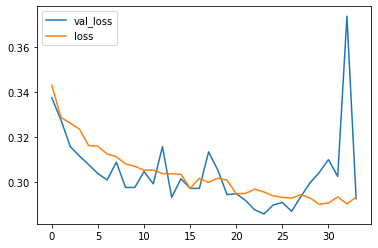

In [31]:
hist1[['val_loss', 'loss']].plot()

<AxesSubplot:>

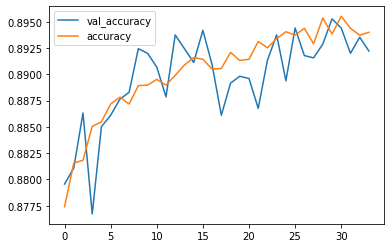

In [32]:
hist1[['val_accuracy', 'accuracy']].plot()

In [33]:
from sklearn.metrics import classification_report

In [35]:
preds = model1.predict(x2_1)
new_preds = []
for i in preds:
    if i > 0.5:
        new_preds.append(1)
    else:
        new_preds.append(0)
        
print(classification_report(y2_1, new_preds))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      3995
         1.0       0.73      0.26      0.38       588

    accuracy                           0.89      4583
   macro avg       0.81      0.62      0.66      4583
weighted avg       0.88      0.89      0.87      4583



In [57]:
# training a new model with best hyperparams to the labelled view 2

params = iter1['params1']
model2 = build_model(params)
x1_2, x2_2, y1_2, y2_2 = scaled_splits(iter1['v2_l'])
history2 = model1.fit(x1_2, y1_2, epochs=100, validation_data = (x2_2, y2_2), callbacks=[early_stop])
hist2 = pd.DataFrame(history2.history)

Epoch 1/100
721/721 [==============================] - 3s 4ms/step - loss: 0.3296 - accuracy: 0.8986 - val_loss: 0.3226 - val_accuracy: 0.9012
Epoch 2/100
721/721 [==============================] - 3s 4ms/step - loss: 0.3284 - accuracy: 0.8986 - val_loss: 0.3226 - val_accuracy: 0.9012
Epoch 3/100
721/721 [==============================] - 3s 4ms/step - loss: 0.3283 - accuracy: 0.8986 - val_loss: 0.3226 - val_accuracy: 0.9012
Epoch 4/100
721/721 [==============================] - 3s 4ms/step - loss: 0.3283 - accuracy: 0.8986 - val_loss: 0.3227 - val_accuracy: 0.9012
Epoch 5/100
721/721 [==============================] - 3s 4ms/step - loss: 0.3283 - accuracy: 0.8986 - val_loss: 0.3225 - val_accuracy: 0.9012
Epoch 6/100
721/721 [==============================] - 3s 4ms/step - loss: 0.3283 - accuracy: 0.8986 - val_loss: 0.3227 - val_accuracy: 0.9012
Epoch 7/100
721/721 [==============================] - 3s 4ms/step - loss: 0.3284 - accuracy: 0.8986 - val_loss: 0.3226 - val_accuracy: 0.9012

<AxesSubplot:>

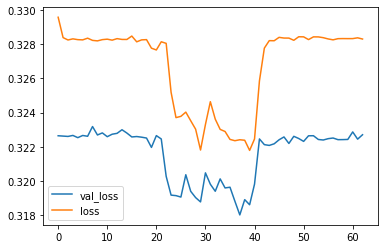

In [58]:
hist2[['val_loss', 'loss']].plot()

In [59]:
from sklearn.metrics import classification_report

In [62]:
preds = model2.predict(x2_2)
new_preds = []
for i in preds:
    if i > np.percentile(preds, 90):
        new_preds.append(1)
    else:
        new_preds.append(0)
        

array([[0.50082254],
       [0.49670234],
       [0.50605434],
       ...,
       [0.50440586],
       [0.5047253 ],
       [0.50120175]], dtype=float32)

In [65]:
print(classification_report(y2_2, new_preds))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      5197
         1.0       0.11      0.11      0.11       570

    accuracy                           0.82      5767
   macro avg       0.51      0.51      0.51      5767
weighted avg       0.82      0.82      0.82      5767

